Looking at 224x224 patch dataset, based on CASIA1.
=============


In [5]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve

from tensorflow.python import pywrap_tensorflow
from tensorflow.python.platform import app
from tensorflow.python.platform import flags


# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

Some functions

In [2]:
def display_image_rgb(data, width, height):
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    myshape = picture.shape
    picture = np.swapaxes(picture,0,1)
    picture = np.swapaxes(picture,1,2)    
    plt.imshow(picture)
    plt.axis("off")
    plt.show()    

def add_grid_lines(data, width, height, gridH, gridV):
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    myshape = picture.shape
    picture[:, 0:width:gridH, :] = 0
    picture[:, :, 0:height:gridV] = 0
    picture = picture.reshape((width*height*3), )
    return picture

    


    
def display_image_yuv(data, width, height):
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    myshape = picture.shape
    picture = picture[0]
    #plt.imshow(picture, cmap="hot")
    plt.imshow(picture, cmap="gray")
    plt.axis("off")
    plt.show()    

def thresholdAndRound(y):
    maxn = 255
    minn = 0
    y[y > maxn] = maxn
    y[y < minn] = minn
    y = np.around(y,0)
    return y

def convertToBytes(y):
    y = np.asarray(y, 'u1')
    return y


#Note that this function takes as input a planar RGB image
# It returns planar YUV4:4:4 (it's not common but it can be downsampled to 4:2:0)
def planarRGB_2_planarYUV(data, width, height):
    #print("in planarRGB_2_planarYUV")
    delta = 128.0
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    r = np.array(picture[0])
    g = np.array(picture[1])
    b = np.array(picture[2])
    #print("orig R:" + str(r[0]))
    #print("orig G:" + str(g[0]))
    #print("orig B:" + str(b[0]))

    y = np.array(0.299*r + 0.587*g + 0.114*b)
    y = thresholdAndRound(y)
    u = ((b-y)*0.564) + delta
    v = ((r-y)*0.713) + delta
    
    #print("orig Y:" + str(y[0]))
    #print("orig U:" + str(u[0]))
    #print("orig V:" + str(v[0]))

    y = thresholdAndRound(y)
    u = thresholdAndRound(u)
    v = thresholdAndRound(v)
    y = convertToBytes(y)
    u = convertToBytes(u)
    v = convertToBytes(v)
    
    yuv = np.concatenate((y,u,v), axis = 0)
    yuv = yuv.reshape((width*height*3), )

    #print(y)
    #print(v)

    return yuv

def YUV444_2_YUV420(data, width, height):
    from scipy import signal
    #print("YUV444_2_YUV420")
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    y = picture[0]
    u = picture[1]
    v = picture[2]

    #shape = u.shape
    #print("The old shape of u: "+ str(shape))
    #print(u)

    kernel = np.array([[1,1,0],
                       [1,1,0],
                       [0,0,0]]) 

    # Perform 2D convolution with input data and kernel 
    u = signal.convolve2d(u, kernel, mode='same')/kernel.sum()
    u = u[::2, ::2].copy()
    v = signal.convolve2d(v, kernel, mode='same')/kernel.sum()
    v = v[::2, ::2].copy()
    
    y = y.flatten()
    u = u.flatten()
    v = v.flatten()
    
    #shape = u.shape
    #print("The new shape of u: "+ str(shape))
    yuv = np.concatenate([y,u,v])
    return yuv

def YUV420_2_YUV444(data, width, height):
    from scipy import signal
    print("YUV420_2_YUV444")
    picture = np.array(data)
    picSize = width*height
    #picture = pic_planar.reshape(3, width, height)
    y = np.array(picture[0:picSize])
    
    u = np.array(picture[picSize:(picSize*5/4)])
    u = u.reshape((width/2), (height/2))
    #print("The old shape of u: "+ str(u.shape))
    #print(u)             
    u = np.repeat(u, 2, axis=0)
    #print("The new shape of u: "+ str(u.shape))
    #print(u)
    u = np.repeat(u, 2, axis=1)
    #print("The new shape of u: "+ str(u.shape))
    #print(u)

    v = np.array(picture[(picSize*5/4):])
    v = v.reshape((width/2), (height/2))
    #print("The old shape of v: "+ str(v.shape))
    #print(v)             
    v = np.repeat(v, 2, axis=0)
    #print("The new shape of v: "+ str(v.shape))
    #print(u)
    v = np.repeat(v, 2, axis=1)
    #print("The new shape of v: "+ str(v.shape))
    #print(v)


    y = y.flatten()
    u = u.flatten()
    v = v.flatten()
    
    #shape = u.shape
    #print("The new shape of u: "+ str(shape))
    yuv = np.concatenate([y,u,v])
    return yuv



    

# planar YUV 4:4:4 to rgb
def planarYUV_2_planarRGB(data, width, height):
    #print("in planarYUV_2_planarRGB")
    maxn = 255
    minn = 0
    delta = 128.0
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    y = picture[0]
    u = picture[1]
    v = picture[2]
    
    #print("recon Y:" + str(y[0]))
    #print("recon U:" + str(u[0]))
    #print("recon V:" + str(v[0]))

    
    r = y + 1.403 * (v-delta)
    g = y - (0.714 * (v-delta)) - (0.344 * (u-delta)) 
    b = y + 1.773 * (u-delta)

    #r = y + 1.13983 * v
    #g = y - (0.58060 * v) - (0.39465 * u) 
    #b = y + (2.03211 * u)


    r = thresholdAndRound(r)
    r = convertToBytes(r)
    g = thresholdAndRound(g)
    g = convertToBytes(g)
    b = thresholdAndRound(b)
    b = convertToBytes(b)
    #print("Reconstructed r:" + str(r[0]))
    #print("Reconstructed g:" + str(g[0]))
    #print("Reconstructed b:" + str(b[0]))

    rgb = np.concatenate((r,g,b), axis = 0)
    rgb = rgb.reshape((width*height*3), )
    return rgb

def quantiseUV(data, width, height):
    numLevels = 16
    q = 256/numLevels
    x = np.linspace(0, 10, 1000)
    
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    y = picture[0]
    u = picture[1]
    v = picture[2]
    
    u = q * np.round(u/q)
    v = q * np.round(v/q)

    yuv = np.concatenate((y,u,v), axis = 0)
    yuv = yuv.reshape((width*height*3), )
    return yuv

def saveToFile(data, filename):
    datayuv = np.asarray(data, 'u1')
    yuvByteArray = bytearray(datayuv)
    mylen = len(yuvByteArray)
    yuvFile = open(filename, "wb")
    yuvFile.write(yuvByteArray)
    yuvFile.close()

def appendToFile(data, filename):
    datayuv = np.asarray(data, 'u1')
    yuvByteArray = bytearray(datayuv)
    mylen = len(yuvByteArray)
    #print("Adding bytes to file: "+str(mylen))
    yuvFile = open(filename, "ab")
    yuvFile.write(yuvByteArray)
    yuvFile.close()
    
def doubleImage(data, width, height):
    doubleW = width*2
    doubleH = height*2
    import PIL
    rgbframe = planarYUV_2_planarRGB(data, height, width)
    test = np.asarray(rgbframe, 'u1')
    pictureA = test.reshape(3, height, width)
    pictureA = np.swapaxes(pictureA,0,1)
    pictureA = np.swapaxes(pictureA,1,2)
    pictureA = np.ndarray.flatten(pictureA)
    imageA = Image.frombytes('RGB', (height, width), pictureA)
    #imgOrig = imageA
    
    imageA = imageA.resize((doubleH,doubleW), PIL.Image.LANCZOS)
    #display(imageA)
    #imageB = imgOrig.resize((doubleH,doubleW), PIL.Image.BICUBIC)
    #display(imageB)

    pixels = list(imageA.getdata())
    pixels = np.asarray(pixels, 'u1')
    pixels = pixels.reshape(doubleH, doubleW, 3)
    pixels = np.swapaxes(pixels,2,1)
    pixels = np.swapaxes(pixels,1,0)
    pixels = pixels.flatten()
    yuvpixels = planarRGB_2_planarYUV(pixels, doubleH, doubleW)
    #pixels = pixels.flatten()
    return yuvpixels




Get the dictionaries and look at the pictures.

(302581251,)
There are 1539 patches in the file
Shape of allTheData array: (1539, 196609)
Shape of labels array: (1539,)
The index of the image is 0, data shape (1539, 196609)
/Volumes/LaCie/data/CASIA1/train_crop.bin
The label is tampered


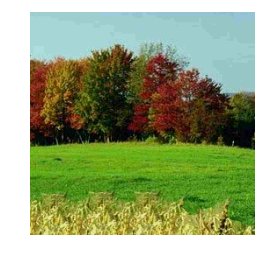

shape of rgb frame: (196608,)


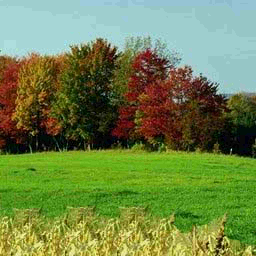

The index of the image is 1, data shape (1539, 196609)
/Volumes/LaCie/data/CASIA1/train_crop.bin
The label is authentic


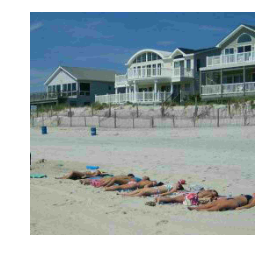

shape of rgb frame: (196608,)


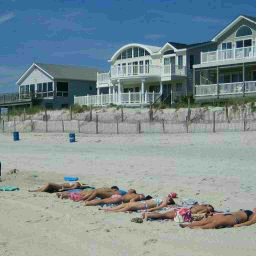

The index of the image is 2, data shape (1539, 196609)
/Volumes/LaCie/data/CASIA1/train_crop.bin
The label is tampered


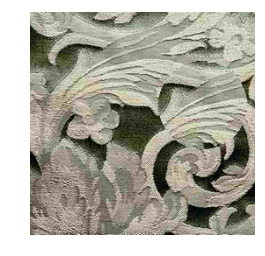

shape of rgb frame: (196608,)


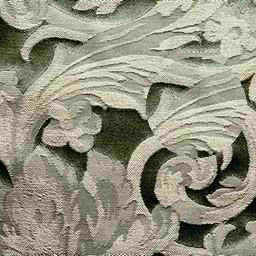

The index of the image is 3, data shape (1539, 196609)
/Volumes/LaCie/data/CASIA1/train_crop.bin
The label is tampered


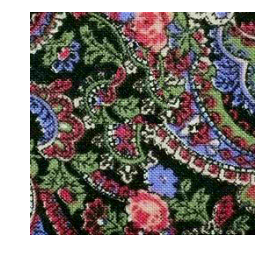

shape of rgb frame: (196608,)


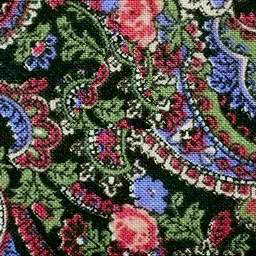

The index of the image is 42, data shape (1539, 196609)
/Volumes/LaCie/data/CASIA1/train_crop.bin
The label is authentic


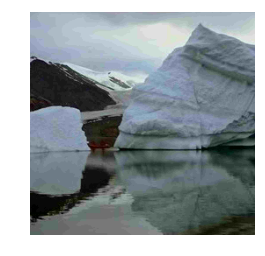

shape of rgb frame: (196608,)


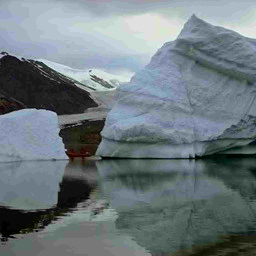

The index of the image is 43, data shape (1539, 196609)
/Volumes/LaCie/data/CASIA1/train_crop.bin
The label is authentic


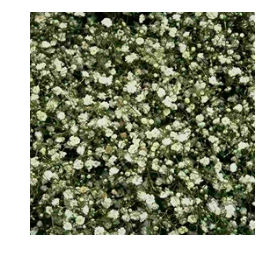

shape of rgb frame: (196608,)


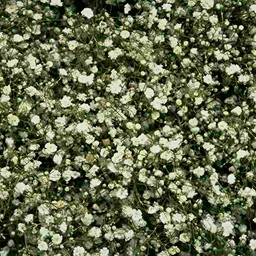

The index of the image is 44, data shape (1539, 196609)
/Volumes/LaCie/data/CASIA1/train_crop.bin
The label is tampered


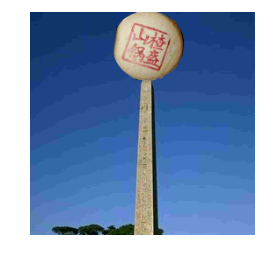

shape of rgb frame: (196608,)


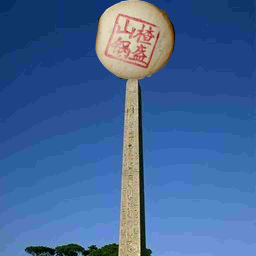

The index of the image is 45, data shape (1539, 196609)
/Volumes/LaCie/data/CASIA1/train_crop.bin
The label is tampered


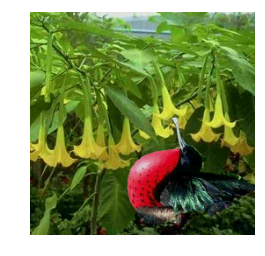

shape of rgb frame: (196608,)


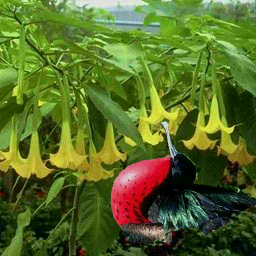

In [8]:
import matplotlib.pyplot as plt
import random
from PIL import Image

data_folder = '/Volumes/LaCie/data/CASIA1/test_crop.bin'
data_folder = '/Volumes/LaCie/data/CASIA1/train_crop.bin'



folderFormat = 'yuv'

width = 256
height = 256
channels = 3
pixel_depth = 8


#num_cases_per_batch = 10000
num_cases_per_batch = 2

label_names = ['authentic', 'tampered']

    
f = open(data_folder, "rb")
allTheData = np.fromfile(f, 'u1')
print(allTheData.shape)
recordSize = (width * height * channels) + 1
num_cases_per_batch = allTheData.shape[0] / recordSize
print("There are {} patches in the file".format(num_cases_per_batch))



allTheData = allTheData.reshape(num_cases_per_batch, recordSize)
data_labels = allTheData[:, 0].copy()
data_array = allTheData[:, 1:].copy()

print("Shape of allTheData array: {}".format(allTheData.shape))
print("Shape of labels array: {}".format(data_labels.shape))


index = random.randint(0,num_cases_per_batch)
index = 0
indexes = [0, 1, 2, 3, 42, 43, 44, 45]

for i in indexes:
    index = i
    print('The index of the image is {}, data shape {}'.format(index, allTheData.shape))
    print(data_folder)


    # Try scaling it up a bit
    scaleUp = False
    if scaleUp == True:
        myframe = data_array[index]
        myframe = myframe * pixel_depth
        myframe = doubleImage(myframe, height, width)
        rgbframe = planarYUV_2_planarRGB(myframe, (height*2), (width*2))
        print("displaying double sized frame")
        display_image_rgb(rgbframe, (height*2), (width*2))
    #end scaling it

    label = label_names[data_labels[index]]
    print("The label is {}".format(label_names[data_labels[index]]))
    test_data_array = data_array

    filename = "patch{}_mbmode_{}.png".format(index, label)

    if folderFormat == 'rgb':
        rgbframe = test_data_array[index]
    elif folderFormat == 'yuv':
        frame = test_data_array[index]
        frame = frame * pixel_depth
        rgbframe = planarYUV_2_planarRGB(frame, height, width)

    #rgbframe = add_grid_lines(rgbframe, 32, 32, 8, 8)

    display_image_rgb(rgbframe, height, width)
    print("shape of rgb frame: {}".format(rgbframe.shape))
    test = np.asarray(rgbframe, 'u1')
    pictureA = test.reshape(3, width, height)
    pictureA = np.swapaxes(pictureA,0,1)
    pictureA = np.swapaxes(pictureA,1,2)
    pictureA = np.ndarray.flatten(pictureA)

    imageA = Image.frombytes('RGB', (height, width), pictureA)
    display(imageA)
    imageA.save(filename, "PNG")




Looking at the network learned from CASIA1 224x224 patch dataset.
=============



In [14]:
file_name = "train/model.ckpt-14000"
file_name = "train_DGX/train/model.ckpt-34000"



reader = pywrap_tensorflow.NewCheckpointReader(file_name)
var_to_shape_map = reader.get_variable_to_shape_map()
print(reader.debug_string().decode("utf-8"))



conv1/biases (DT_FLOAT) [64]
conv1/biases/ExponentialMovingAverage (DT_FLOAT) [64]
conv1/weights (DT_FLOAT) [5,5,3,64]
conv1/weights/ExponentialMovingAverage (DT_FLOAT) [5,5,3,64]
conv2/biases (DT_FLOAT) [64]
conv2/biases/ExponentialMovingAverage (DT_FLOAT) [64]
conv2/weights (DT_FLOAT) [5,5,64,64]
conv2/weights/ExponentialMovingAverage (DT_FLOAT) [5,5,64,64]
global_step (DT_FLOAT) []
local3/biases (DT_FLOAT) [384]
local3/biases/ExponentialMovingAverage (DT_FLOAT) [384]
local3/weights (DT_FLOAT) [12544,384]
local3/weights/ExponentialMovingAverage (DT_FLOAT) [12544,384]
local4/biases (DT_FLOAT) [192]
local4/biases/ExponentialMovingAverage (DT_FLOAT) [192]
local4/weights (DT_FLOAT) [384,192]
local4/weights/ExponentialMovingAverage (DT_FLOAT) [384,192]
softmax_linear/biases (DT_FLOAT) [2]
softmax_linear/biases/ExponentialMovingAverage (DT_FLOAT) [2]
softmax_linear/weights (DT_FLOAT) [192,2]
softmax_linear/weights/ExponentialMovingAverage (DT_FLOAT) [192,2]
tower_0/conv1/weight_loss/avg (D

In [25]:
#for key in sorted(var_to_shape_map):
#    print("tensor_name: ", key)
#    print(reader.get_tensor(key))
    
conv1_weights = reader.get_tensor("conv1/weights")
conv1_biases = reader.get_tensor("conv1/biases")

print("The weights shape {}".format(conv1_weights.shape))
print("The biases shape {}".format(conv1_biases.shape))


conv1_weights = np.swapaxes(conv1_weights,1,2)
conv1_weights = np.swapaxes(conv1_weights,0,1)

print("The weights shape {}".format(conv1_weights.shape))

#print(conv1_weights)
#print(conv1_biases)

# Let's try applying the biases

conv1_combo = conv1_weights + conv1_biases
#print(conv1_combo)

print("The max value in the weights: {}".format(conv1_weights.max()))
print("The min value in the weights: {}".format(conv1_weights.min()))

c1w_min = conv1_combo.min()
c1w = conv1_combo - c1w_min
c1w = c1w * (255.0/c1w.max())
# round
c1w = np.rint(c1w)

print("The first weight and biases as float:")
print(conv1_combo[0,:,:,0])

print("The first weight:")
print(c1w[0,:,:,0])
print("The weights shape {}".format(c1w.shape))

width =  c1w.shape[1]
height = c1w.shape[2]

print("Dimensions {} by {}".format(width, height))


The weights shape (5, 5, 3, 64)
The biases shape (64,)
The weights shape (3, 5, 5, 64)
The max value in the weights: 0.344856530428
The min value in the weights: -0.300767362118
The first weight and biases as float:
[[-0.10833202 -0.13472962 -0.26464155 -0.31350634 -0.30793437]
 [-0.19573227 -0.28591198 -0.29350924 -0.24789324 -0.31626153]
 [-0.23607181 -0.31888965 -0.3588348  -0.18269573 -0.30431527]
 [-0.30671912 -0.28189659 -0.29256839 -0.3143816  -0.36691123]
 [-0.27943379 -0.32553861 -0.25267354 -0.27421182 -0.3209269 ]]
The first weight:
[[ 119.  111.   74.   60.   61.]
 [  94.   68.   65.   79.   59.]
 [  82.   58.   47.   97.   62.]
 [  62.   69.   66.   59.   44.]
 [  69.   56.   77.   71.   57.]]
The weights shape (3, 5, 5, 64)
Dimensions 5 by 5


Number kernels 64
(3, 5, 5)


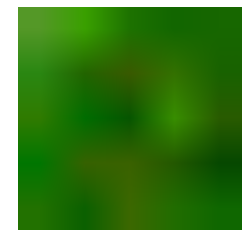

(3, 5, 5)


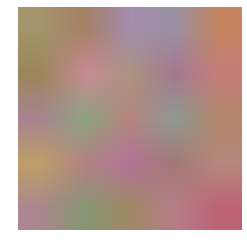

(3, 5, 5)


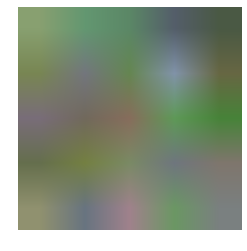

(3, 5, 5)


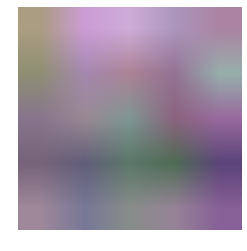

(3, 5, 5)


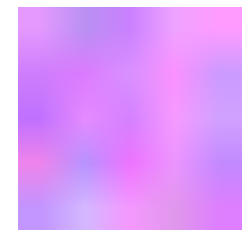

(3, 5, 5)


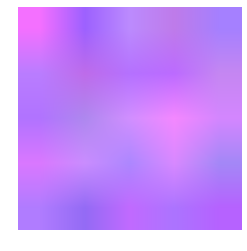

(3, 5, 5)


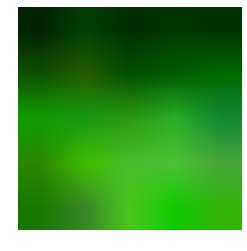

(3, 5, 5)


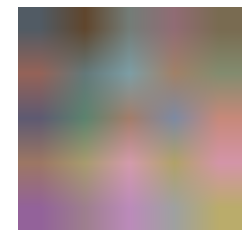

(3, 5, 5)


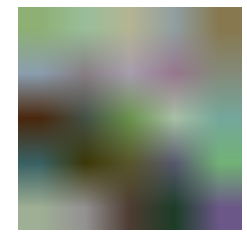

(3, 5, 5)


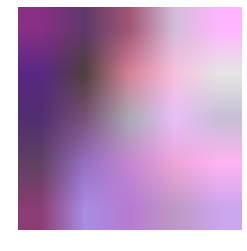

(3, 5, 5)


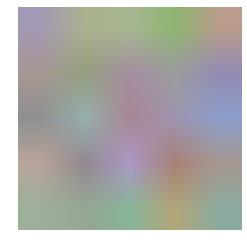

(3, 5, 5)


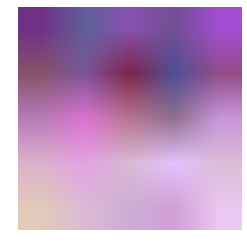

(3, 5, 5)


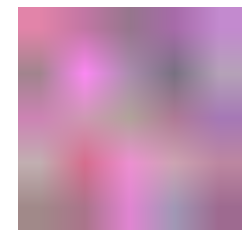

(3, 5, 5)


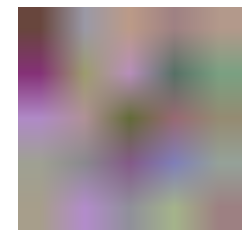

(3, 5, 5)


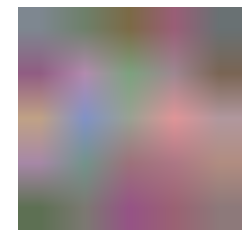

(3, 5, 5)


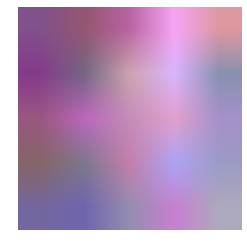

(3, 5, 5)


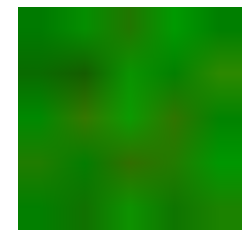

(3, 5, 5)


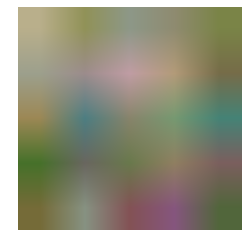

(3, 5, 5)


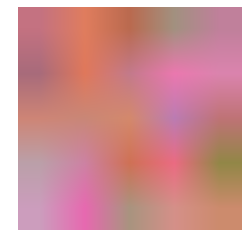

(3, 5, 5)


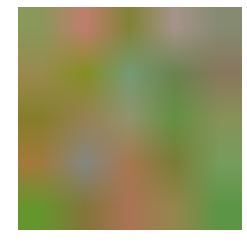

(3, 5, 5)


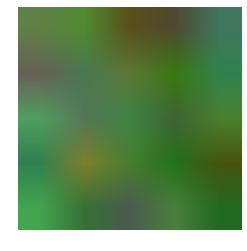

(3, 5, 5)


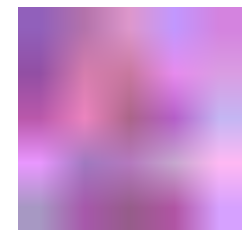

(3, 5, 5)


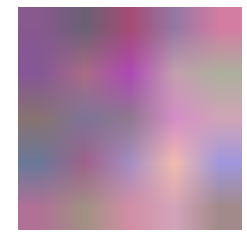

(3, 5, 5)


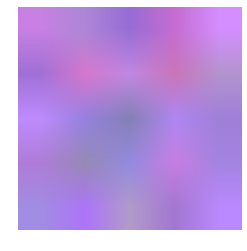

(3, 5, 5)


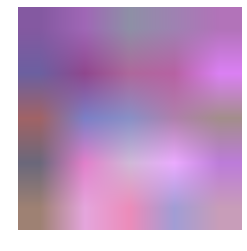

(3, 5, 5)


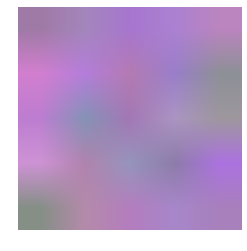

(3, 5, 5)


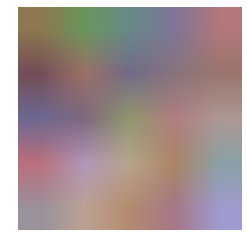

(3, 5, 5)


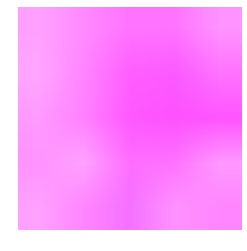

(3, 5, 5)


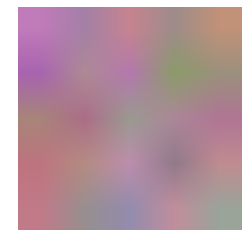

(3, 5, 5)


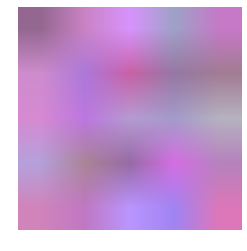

(3, 5, 5)


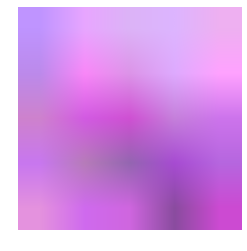

(3, 5, 5)


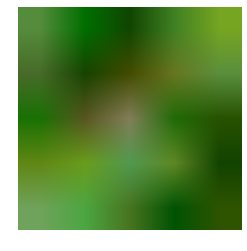

(3, 5, 5)


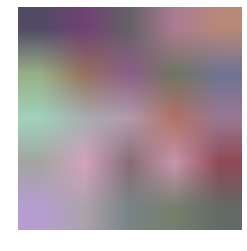

(3, 5, 5)


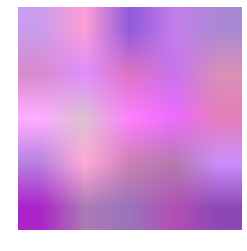

(3, 5, 5)


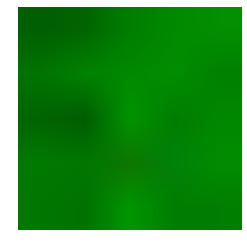

(3, 5, 5)


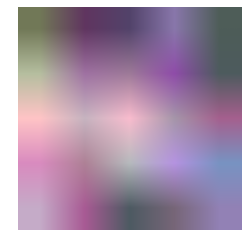

(3, 5, 5)


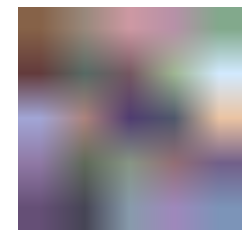

(3, 5, 5)


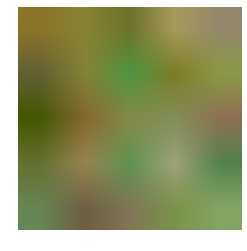

(3, 5, 5)


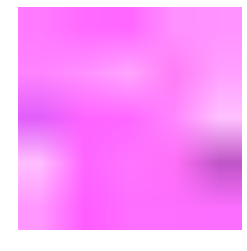

(3, 5, 5)


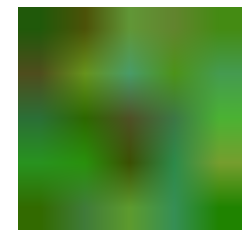

(3, 5, 5)


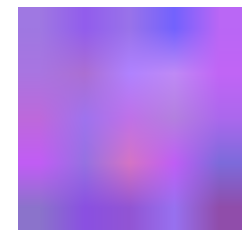

(3, 5, 5)


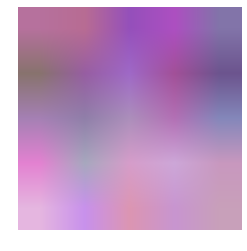

(3, 5, 5)


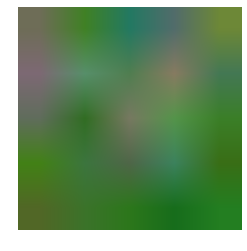

(3, 5, 5)


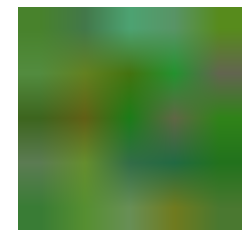

(3, 5, 5)


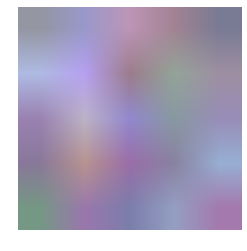

(3, 5, 5)


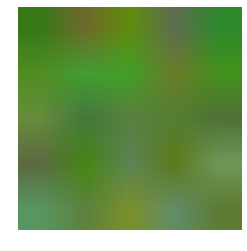

(3, 5, 5)


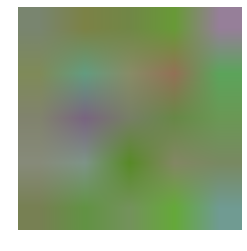

(3, 5, 5)


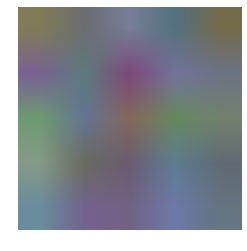

(3, 5, 5)


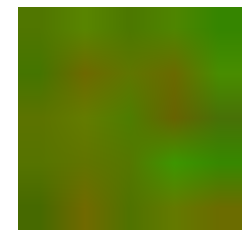

(3, 5, 5)


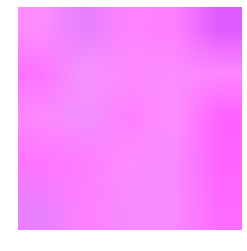

(3, 5, 5)


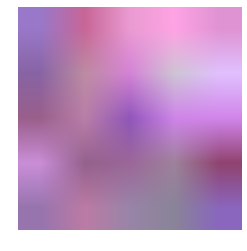

(3, 5, 5)


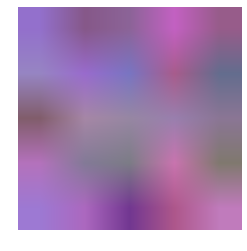

(3, 5, 5)


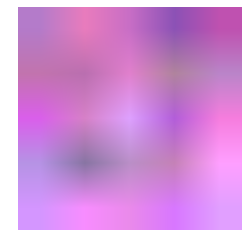

(3, 5, 5)


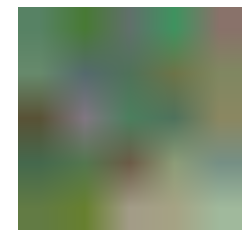

(3, 5, 5)


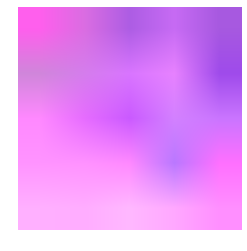

(3, 5, 5)


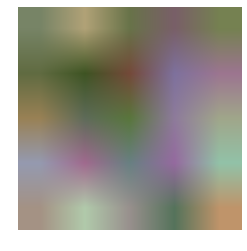

(3, 5, 5)


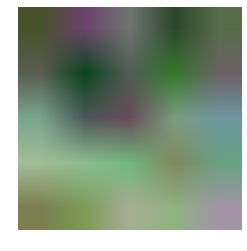

(3, 5, 5)


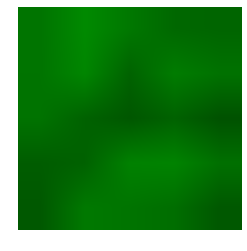

(3, 5, 5)


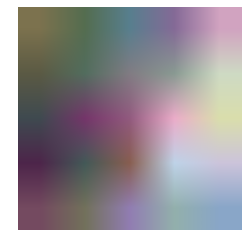

(3, 5, 5)


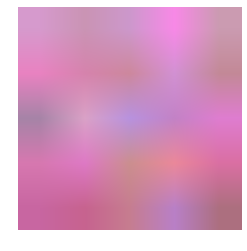

(3, 5, 5)


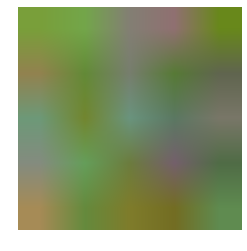

(3, 5, 5)


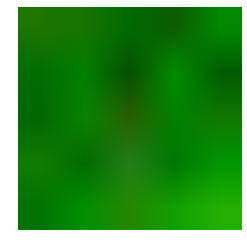

(3, 5, 5)


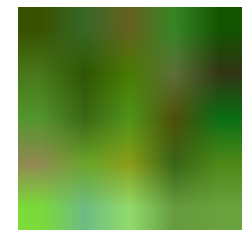

(3, 5, 5)


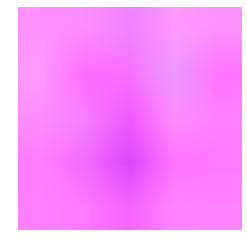

In [16]:
def display_image_rgb(data, width, height, interp_method='bilinear'):
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    myshape = picture.shape

    picture = np.swapaxes(picture,0,1)
    picture = np.swapaxes(picture,1,2)    

    plt.imshow(picture, interpolation=interp_method)
    plt.axis("off")
    plt.show()    

numKers = c1w.shape[3]
print("Number kernels {}".format(numKers))
width = 5
height = 5

for x in range(0,c1w.shape[3]):
    yuv_data = c1w[:,:,:,x].copy()
    print(yuv_data.shape)
    #print(yuv_data)
    yuv_data = yuv_data.flatten()
    rgbpic = planarYUV_2_planarRGB(yuv_data, width, height)
    display_image_rgb(rgbpic, width, height)

(3, 5, 5, 64)
4800


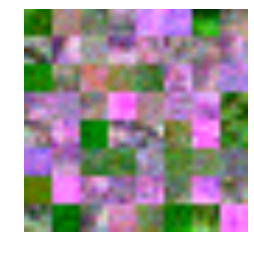

In [19]:
print(c1w.shape)
tryAgain = []
idx = 0
for c in range (0,3):
    for ky in range(0,8):
        for y in range(0,5):
            for kx in range(0,8):
                yuv_data = c1w[c,y,:,(ky*8)+kx].copy()
                #yuv_data = yuv_data.flatten()
                #print("The {} data: {}".format(idx, yuv_data))
                tryAgain.extend(yuv_data)
                idx = idx + 1


width = 5*8
height = 5*8
kernelwidth =  c1w.shape[1]
kernelheight = c1w.shape[2]

yuv_data = tryAgain
print(len(yuv_data))
rgbpic = planarYUV_2_planarRGB(yuv_data, width, height)
display_image_rgb(rgbpic, width, height)

(3, 5, 5, 64)
6912


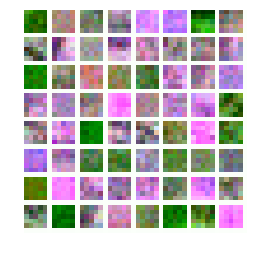

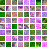

All the green ones have 0 values for U and V (so they're intensity only)


In [26]:
def savePic(saveName, rgbpic, height, width, border=False):
    test = np.asarray(rgbpic, 'u1')
    pictureA = test.reshape(3, height, width)
    pictureA = np.swapaxes(pictureA,0,1)
    pictureA = np.swapaxes(pictureA,1,2)
    pictureA = np.ndarray.flatten(pictureA)

    imageA = Image.frombytes('RGB', (height, width), pictureA)
    #imageB = imageA.resize(( (height*4), (width*4)), PIL.Image.LANCZOS)
    imageB = imageA.resize(( (height*4), (width*4)))

    if border:
        imageA = imageA.crop((-4, -4, height+4, width+4))
        imageB = imageB.crop((-4, -4, (height*4)+4, (width*4)+4))

    display(imageA)
    imageA.save(saveName, "PNG")  
    bigSaveName = "{}_big.png".format(saveName.replace('.png', ''))
    imageB.save(bigSaveName, "PNG")    


def displayKernelMap_withSpaces(c1w, kernelheight, kernelwidth, savePicName):

    print(c1w.shape)
    tryAgain = []
    idx = 0
    for c in range (0,3):
        if c==0: 
            gridValue = 255
        else:
            gridValue = 125
        for ky in range(0,8):
            for y in range(0,kernelheight):
                for kx in range(0,8):
                    yuv_data = c1w[c,y,:,(ky*8)+kx].copy()
                    #yuv_data = yuv_data.flatten()
                    yuv_data = np.append(yuv_data, gridValue)
                    #print("The {} data: {}".format(idx, yuv_data))
                    tryAgain.extend(yuv_data)
                    #tryAgain.append(255)
                    idx = idx + 1
                #Grid lines...
            for kx in range(0,8):
                yuv_data = []
                for x in range(0, kernelwidth+1):
                    yuv_data = np.append(yuv_data, gridValue)
                #print("The {} data: {}".format(idx, yuv_data))
                tryAgain.extend(yuv_data)
                #tryAgain.append(255)
                #idx = idx + 1



    width = (kernelwidth+1)*8
    height = (kernelheight+1)*8


    yuv_data = tryAgain
    print(len(yuv_data))
    rgbpic = planarYUV_2_planarRGB(yuv_data, width, height)
    display_image_rgb(rgbpic, width, height, "none")


    savePic(savePicName, rgbpic, height, width)

myFilterPictureName = "filterpicture.png"

displayKernelMap_withSpaces(c1w, kernelheight, kernelwidth, myFilterPictureName)

print("All the green ones have 0 values for U and V (so they're intensity only)")

